In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *
#to check utils.py is working properly, run "import utils" and "utils.__file__" in a separate notebook file
#may need to install other packages

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
photos = pd.read_csv("multilabel_living_and_nonliving.csv")
print("Number of photos: {}\n".format(len(photos)))
photos.head(3)

Number of photos: 77



,Image Location,Labels
0,Multicategory_Both_8/training/bird/blackbird.jpg,Bird|Living
1,Multicategory_Both_8/training/bird/bluebird.jpg,Bird|Living
2,Multicategory_Both_8/training/bird/brownbird.jpg,Bird|Living


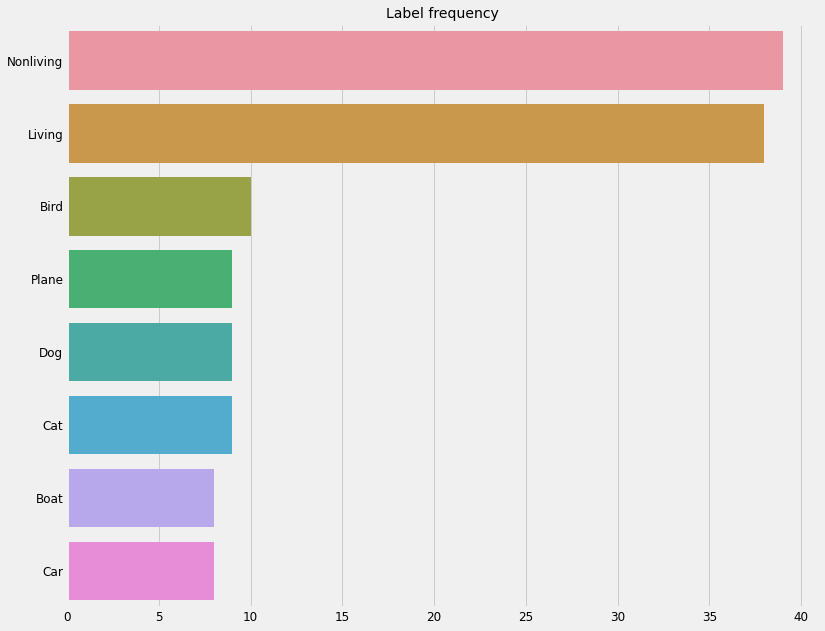

In [3]:
# Get label frequencies in descending order
label_freq = photos['Labels'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [4]:
# Transform Labels into a list of labels
photos['Labels'] = photos['Labels'].apply(lambda s: [l for l in str(s).split('|')])
photos.head()

,Image Location,Labels
0,Multicategory_Both_8/training/bird/blackbird.jpg,"[Bird, Living]"
1,Multicategory_Both_8/training/bird/bluebird.jpg,"[Bird, Living]"
2,Multicategory_Both_8/training/bird/brownbird.jpg,"[Bird, Living]"
3,Multicategory_Both_8/training/bird/chicken.png,"[Bird, Living]"
4,Multicategory_Both_8/training/bird/duck.png,"[Bird, Living]"


In [5]:
X_train, X_val, y_train, y_val = train_test_split(photos['Image Location'], photos['Labels'], test_size=0.2, random_state=44)
print("Number of photos for training: ", len(X_train))
print("Number of photos for validation: ", len(X_val))

Number of photos for training:  61
Number of photos for validation:  16


In [6]:
X_train = [os.path.join(str(f)) for f in X_train]
X_val = [os.path.join(str(f)) for f in X_val]
X_train[:3]

['Multicategory_Both_8/training/cat/pawcat.jpg',
 'Multicategory_Both_8/training/cat/tabbycat.jpg',
 'Multicategory_Both_8/training/car/silvercar.png']

In [7]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['Cat', 'Living'], ['Cat', 'Living'], ['Car', 'Nonliving']]

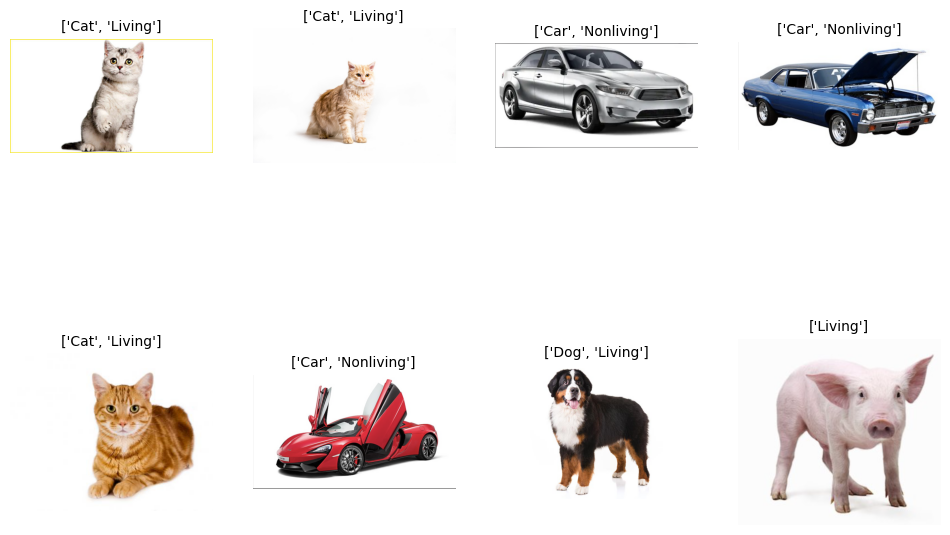

In [8]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

#set nobs to full dataset sizes and replace train with val to check both train and val datasets

In [9]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. Bird
1. Boat
2. Car
3. Cat
4. Dog
5. Living
6. Nonliving
7. Plane


In [10]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [11]:
# Print example of images and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

Multicategory_Both_8/training/cat/pawcat.jpg [0 0 0 1 0 1 0 0]
Multicategory_Both_8/training/cat/tabbycat.jpg [0 0 0 1 0 1 0 0]
Multicategory_Both_8/training/car/silvercar.png [0 0 1 0 0 0 1 0]


In [12]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [13]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [14]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [15]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [16]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [17]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (61, 224, 224, 3)
Shape of labels array: (61, 8)


In [18]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
#to solve SSLCertVerificationError on Mac go to the Python 3.8 (or appropriate version) folder in 
#Applications and double click on Install Certificates.command

In [19]:
feature_extractor_layer.trainable = False

In [20]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 8)                 8200      
Total params: 3,577,928
Trainable params: 1,319,944
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.65305036 0.5367985  0.54557765 0.54319847 0.47920927 0.51593554
  0.35483998 0.6505532 ]]


In [22]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [23]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [24]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [26]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.7278 - macro_f1: 0.2588 - val_loss: 0.7350 - val_macro_f1: 0.3615
Epoch 2/30
1/1 [==============================] - 0s 302ms/step - loss: 0.7249 - macro_f1: 0.2766 - val_loss: 0.7333 - val_macro_f1: 0.3615
Epoch 3/30
1/1 [==============================] - 0s 299ms/step - loss: 0.7220 - macro_f1: 0.2910 - val_loss: 0.7317 - val_macro_f1: 0.3704
Epoch 4/30
1/1 [==============================] - 0s 299ms/step - loss: 0.7192 - macro_f1: 0.2956 - val_loss: 0.7300 - val_macro_f1: 0.3771
Epoch 5/30
1/1 [==============================] - 0s 298ms/step - loss: 0.7163 - macro_f1: 0.3071 - val_loss: 0.7284 - val_macro_f1: 0.3886
Epoch 6/30
1/1 [==============================] - 0s 301ms/step - loss: 0.7136 - macro_f1: 0.3195 - val_loss: 0.7268 - val_macro_f1: 0.3886
Epoch 7/30
1/1 [==============================] - 0s 327ms/step - loss: 0.7108 - macro_f1: 0.3359 - val_loss: 0.7253 - val_macro_f1: 0.3886
Epoch 8/30
1/1 [=======

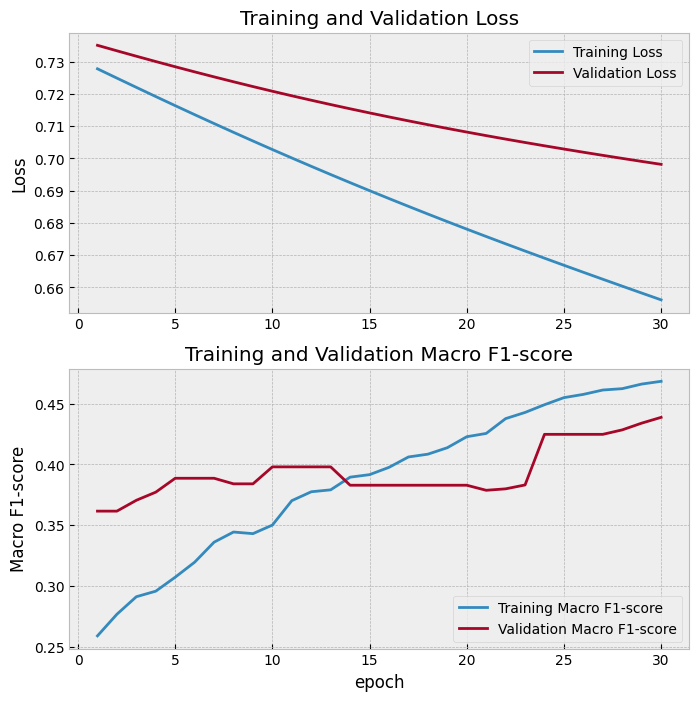

In [27]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

In [28]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.70
Macro F1-score: 0.44


In [29]:
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/30
1/1 [==============================] - 1s 923ms/step - loss: 0.7647 - macro_f1: 0.2672 - val_loss: 0.6762 - val_macro_f1: 0.3068
Epoch 2/30
1/1 [==============================] - 0s 326ms/step - loss: 0.7061 - macro_f1: 0.2728 - val_loss: 0.6269 - val_macro_f1: 0.3460
Epoch 3/30
1/1 [==============================] - 0s 324ms/step - loss: 0.6537 - macro_f1: 0.2636 - val_loss: 0.5840 - val_macro_f1: 0.3503
Epoch 4/30
1/1 [==============================] - 0s 320ms/step - loss: 0.6072 - macro_f1: 0.2815 - val_loss: 0.5473 - val_macro_f1: 0.3614
Epoch 5/30
1/1 [==============================] - 0s 355ms/step - loss: 0.5664 - macro_f1: 0.2519 - val_loss: 0.5160 - val_macro_f1: 0.1864
Epoch 6/30
1/1 [==============================] - 0s 325ms/step - loss: 0.5306 - macro_f1: 0.2302 - val_loss: 0.4897 - val_macro_f1: 0.1981
Epoch 7/30
1/1 [==============================] - 0s 338ms/step - loss: 0.4994 - macro_f1: 0.2188 - val_loss: 0.4677 - val_macro_f1: 0.1844
Epoch 8/30
1/1 [====

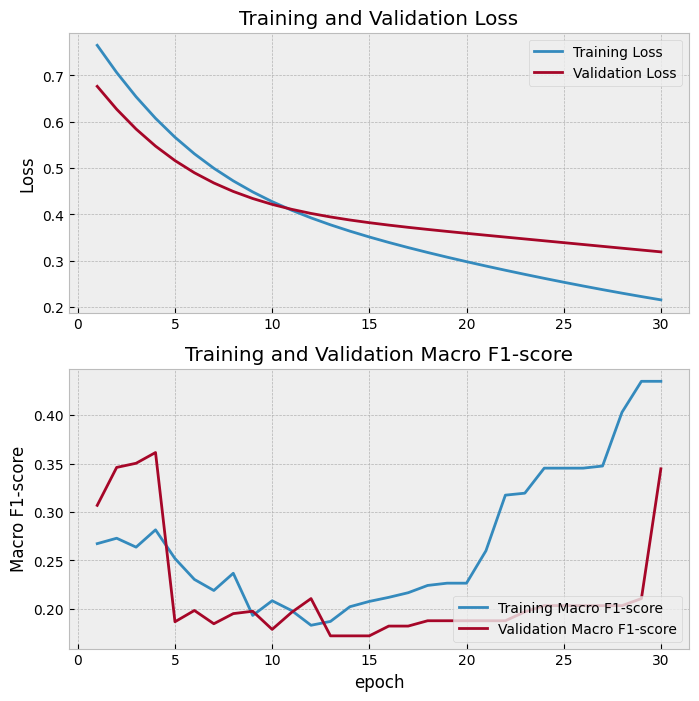

In [30]:
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(history_bce)

In [31]:
print("Macro soft-F1 loss: %.2f" %model_bce_val_losses[-1])
print("Macro F1-score: %.2f" %model_bce_val_macro_f1s[-1])

Macro soft-F1 loss: 0.32
Macro F1-score: 0.34


In [32]:
# Get all label names
label_names = mlb.classes_
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(val_ds, y_val_bin, label_names, model)
# Performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

In [33]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,Bird,0.25,0.00,4,0,12,0.250000,1.0,0.400000
1,0,Bird,0.25,0.01,4,0,12,0.250000,1.0,0.400000
2,0,Bird,0.25,0.02,2,2,11,0.153846,0.5,0.235294
3,0,Bird,0.25,0.03,2,2,11,0.153846,0.5,0.235294
4,0,Bird,0.25,0.04,2,2,10,0.166667,0.5,0.250000


In [34]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,5,Living,0.500000,0.727273
1,6,Nonliving,0.500000,0.700000
2,4,Dog,0.060000,0.666667
3,7,Plane,0.250000,0.666667
4,0,Bird,0.250000,0.400000
5,3,Cat,0.060000,0.333333
6,1,Boat,0.060000,0.133333
7,2,Car,0.000000,0.000000


In [35]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" 
          %max_perf['freq'].corr(max_perf['f1max_bce']))

Correlation between label frequency and optimal F1 with bce: 0.73


In [36]:
top5 = max_perf.head(5)['id']

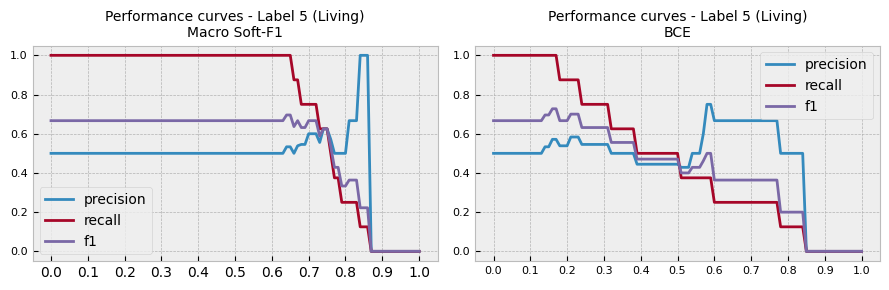

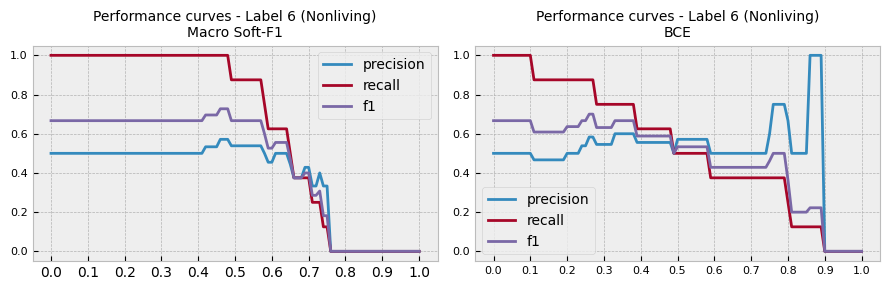

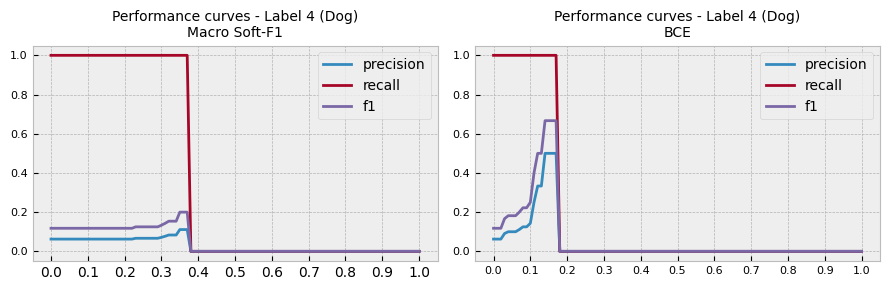

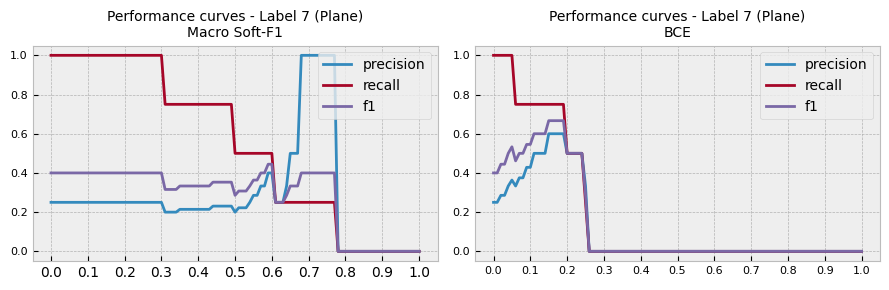

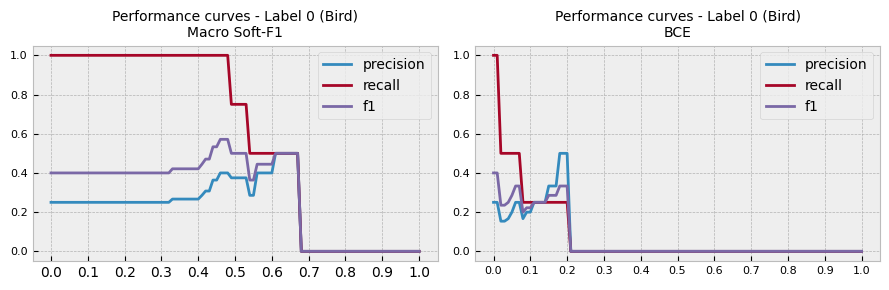

In [37]:
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()

In [38]:
# Predict on the validation set with both models
y_hat_val = model.predict(val_ds)
y_hat_val_bce = model_bce.predict(val_ds)

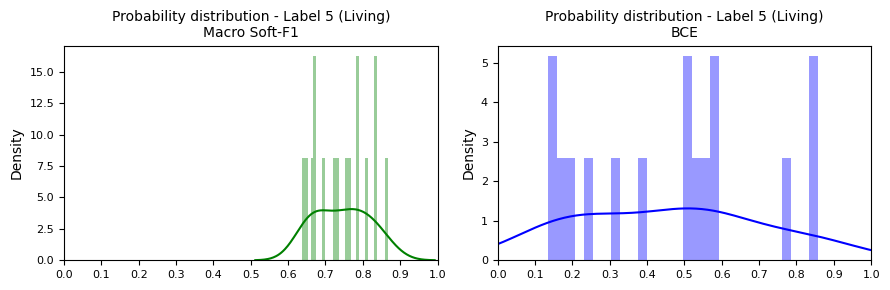

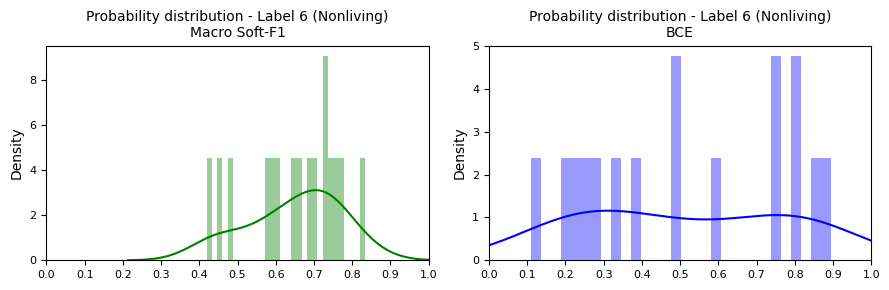

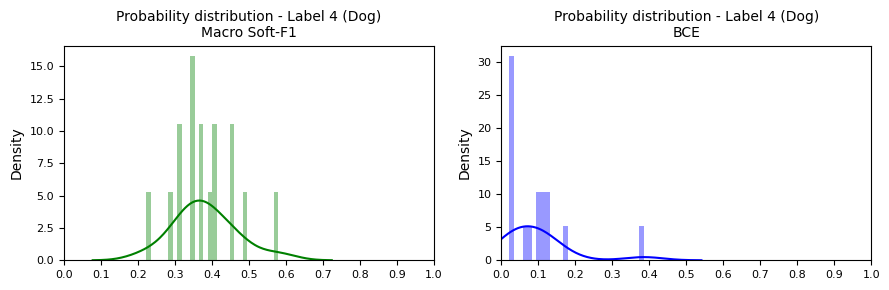

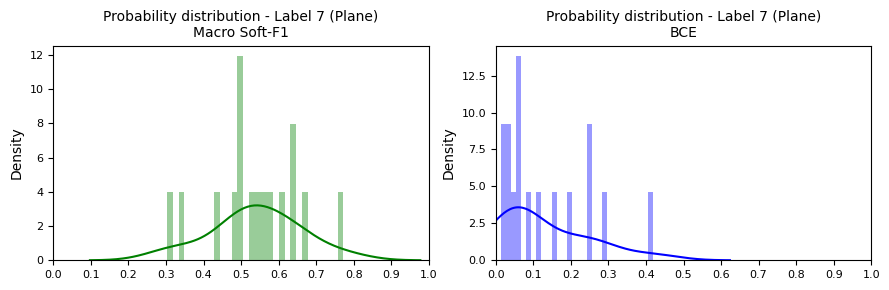

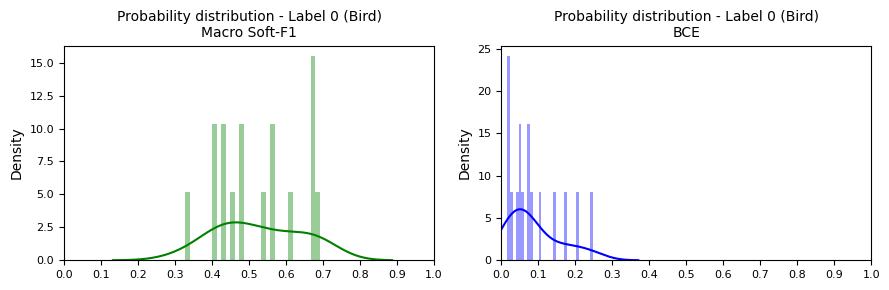

In [39]:
style.use("default")
for l in top5:
        
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val[:,l], bins=30, kde=True, color="g")
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()

In [40]:
def show_prediction(title, movies_df, model):
    
    # Get movie info
    imdbId = movies.loc[movies['Title']==title]['imdbId'].iloc[0]
    genre = movies.loc[movies['Title']==title]['Genre'].iloc[0]
    img_path = os.path.join('./data/movie_poster/images', str(imdbId)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.show()

In [41]:
photos = []

for t in photos:
    show_prediction(t, photos, model)
#need to insert testing dataset here

In [42]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
tf.keras.experimental.export_saved_model(model, export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

export_path_bce = "./models/bce_{}".format(t)
tf.keras.experimental.export_saved_model(model_bce, export_path_bce)
print("Model with bce was exported in this path: '{}'".format(export_path_bce))

AttributeError: module 'tensorflow.keras.experimental' has no attribute 'export_saved_model'

In [43]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.summary()

AttributeError: module 'tensorflow.keras.experimental' has no attribute 'load_from_saved_model'